<a href="https://colab.research.google.com/github/Saumi18/Music-Genre-Classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload the features_3_sec.csv file below:

In [32]:
#Upload the features_3_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_3_sec.csv to features_3_sec (3).csv


Upload the feature_30_sec.csv file below:

In [33]:
#Upload the feature_30_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_30_sec.csv to features_30_sec (3).csv


- Setting Up & Loading Data
- Feature Scaling & Preprocessing

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [35]:
# Drop unnecessary columns
df = df.drop(columns=["filename", "length"])

# Encode genre labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # Encode genres as numbers

# Separate features (X) and labels (y)
X = df.drop(columns=["label"])
y = df["label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Model 1 : KNN

Accuracy for k=3: 0.9555


Text(0, 0.5, 'Accuracy')

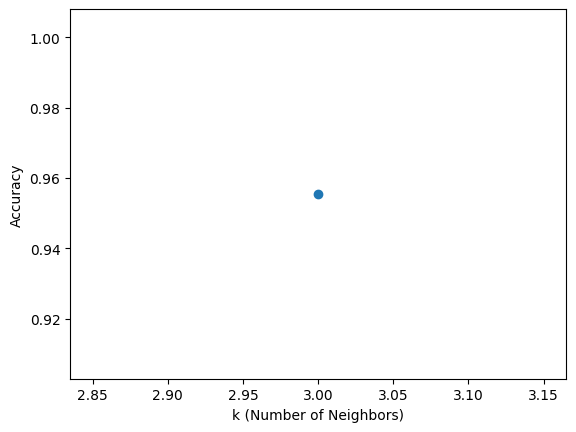

In [39]:
# Model 1: KNN
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

def euclidean_distance(point1, point2):
    """Calculates the Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2)**2))

def get_k_nearest_neighbors(X_train, y_train, test_point, k):
    """Finds the k-nearest neighbors of a test point in the training data."""
    distances = [euclidean_distance(train_point, test_point) for train_point in X_train]
    k_nearest_indices = np.argsort(distances)[:k]  # Get indices of k-nearest neighbors
    # Access y_train using .iloc to ensure positional indexing
    k_nearest_labels = y_train.iloc[k_nearest_indices]  # Get labels of k-nearest neighbors
    return k_nearest_labels

def predict_label(neighbors):
    """Predicts the label of a test point based on its k-nearest neighbors."""
    # Use bincount to find the most frequent label
    labels, counts = np.unique(neighbors, return_counts=True)
    return labels[np.argmax(counts)]

def predict_all_points(X_train, y_train, X_test, k):
    """Predicts labels for all test points in X_test using KNN."""
    predictions = [predict_label(get_k_nearest_neighbors(X_train, y_train, test_point, k)) for test_point in X_test]
    return predictions

# Assuming you have already loaded and preprocessed your data as X_train, y_train

k_values = [3]
train_accuracies = []  # List to store training accuracies

for k in k_values:
    # Calculate training accuracy
    train_predictions = predict_all_points(X_train, y_train, X_train, k)  # Use X_train for training predictions
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)

    print(f"Accuracy for k={k}: {train_accuracy:.4f}")  # Print training accuracy

# Plotting (only training accuracy)
plt.plot(k_values, train_accuracies, marker='o', label="Training Accuracy")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")

Confusion Matrix:
 [[191   1   4   0   1   3   0   0   3   5]
 [  0 196   0   0   0   7   0   0   0   0]
 [ 10   3 159   6   0   2   0   1   4   1]
 [  3   2   0 185   2   0   0   4   0   3]
 [  0   0   8   1 197   1   0   5   6   0]
 [  5  11   5   0   0 170   0   1   0   0]
 [  0   0   0   1   0   0 199   0   0   4]
 [  0   0   5   2   5   2   0 164   1   1]
 [  1   1   3   4   3   0   0   0 199   0]
 [  4   1   9   8   3   0   3   0   2 167]]
Precision: 0.9151515621753735
Recall: 0.9144144144144144


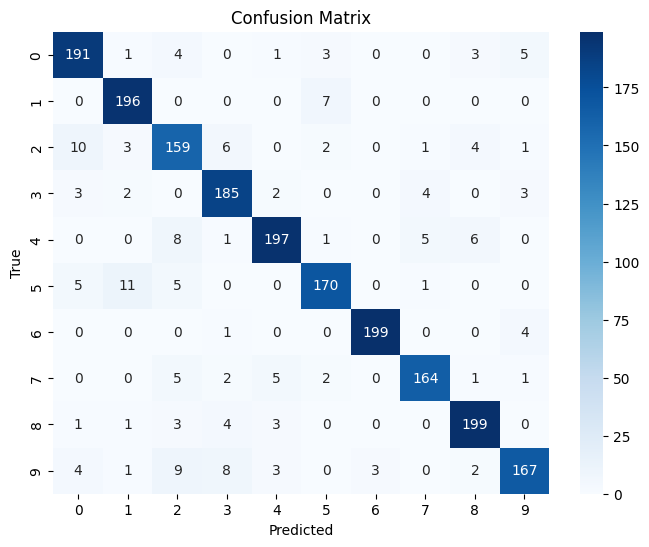

In [40]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Example: y_pred = predict_all_points(X_train, y_train, X_test, k=3)


# Example predictions (replace with your actual predictions):
k = 3
y_pred = predict_all_points(X_train, y_train, X_test, k)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred, average='weighted') # Use 'weighted' or other averaging method as needed.
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred, average='weighted') # Use 'weighted' or other averaging method as needed.
print(f"Recall: {recall}")

# Plotting the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Model 2: SVM

Training class blues vs Rest...
Training class classical vs Rest...
Training class country vs Rest...
Training class disco vs Rest...
Training class hiphop vs Rest...
Training class jazz vs Rest...
Training class metal vs Rest...
Training class pop vs Rest...
Training class reggae vs Rest...
Training class rock vs Rest...
Testing class blues vs Rest...
Testing class classical vs Rest...
Testing class country vs Rest...
Testing class disco vs Rest...
Testing class hiphop vs Rest...
Testing class jazz vs Rest...
Testing class metal vs Rest...
Testing class pop vs Rest...
Testing class reggae vs Rest...
Testing class rock vs Rest...

Classification Report:
              precision    recall  f1-score   support

       blues       0.17      0.92      0.29       208
   classical       0.93      0.94      0.94       203
     country       0.88      0.12      0.22       186
       disco       0.00      0.00      0.00       199
      hiphop       0.88      0.44      0.59       218
        jazz 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


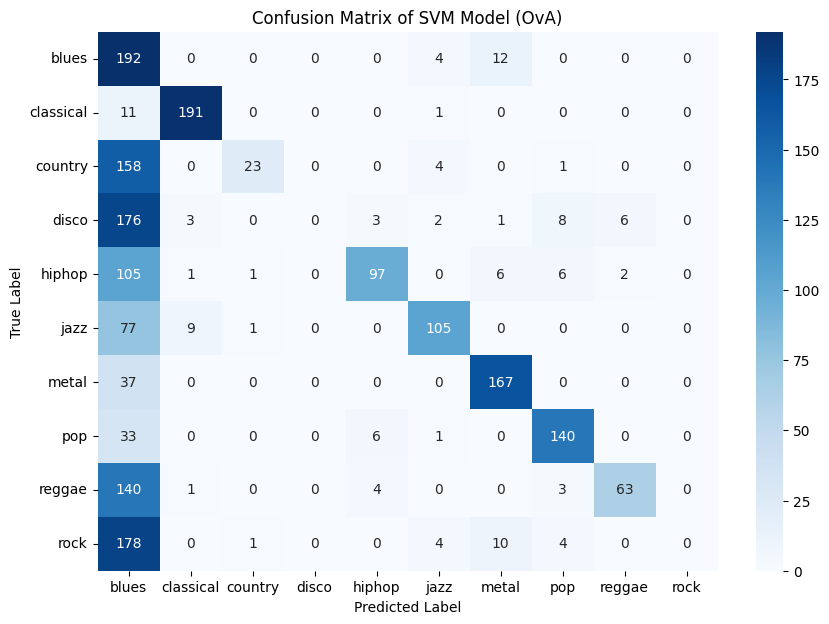

Testing class blues vs Rest...
Testing class classical vs Rest...
Testing class country vs Rest...
Testing class disco vs Rest...
Testing class hiphop vs Rest...
Testing class jazz vs Rest...
Testing class metal vs Rest...
Testing class pop vs Rest...
Testing class reggae vs Rest...
Testing class rock vs Rest...

Visual Testing Examples:
Example 1: Actual = hiphop, Predicted = hiphop
Example 2: Actual = pop, Predicted = pop
Example 3: Actual = rock, Predicted = blues
Example 4: Actual = reggae, Predicted = blues
Example 5: Actual = blues, Predicted = blues


In [ ]:
import random

# Implementing SVM from scratch with gradient descent
class SVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y[idx]))
                    self.bias -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) - self.bias)

# One-vs-All (OvA) SVM Model
class MultiClassSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=2000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}

    def fit(self, X, y):
        unique_classes = np.unique(y)
        for cls in unique_classes:
            print(f"Training class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            y_binary = np.where(y == cls, 1, -1)
            svm = SVM(lr=self.lr, lambda_param=self.lambda_param, n_iters=self.n_iters)
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm

    def predict(self, X):
        predictions = {}
        for cls, svm in self.classifiers.items():
            print(f"Testing class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            predictions[cls] = svm.predict(X)
        return np.array([max(predictions, key=lambda k: predictions[k][i]) for i in range(X.shape[0])])

# Train the custom SVM model
custom_svm = MultiClassSVM(lr=0.0005, lambda_param=0.001, n_iters=3000)
custom_svm.fit(X_train, y_train)

# Make predictions
y_pred = custom_svm.predict(X_test)

# Evaluate model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of SVM Model (OvA)")
plt.show()

# Select a few random test samples for visual testing
random_indices = random.sample(range(len(X_test)), 5)

# Predict the labels for these samples
y_test_samples = np.array(y_test)[random_indices]
y_pred_samples = custom_svm.predict(X_test[random_indices])

# Print actual vs predicted labels
print("\nVisual Testing Examples:")
for i, idx in enumerate(random_indices):
    actual_label = label_encoder.inverse_transform([y_test_samples[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_samples[i]])[0]
    print(f"Example {i+1}: Actual = {actual_label}, Predicted = {predicted_label}")

Model 3 : Decision tree/Random Forest

In [42]:
import random
import math
import numpy as np

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = self._grow_tree(X, y)
            self.trees.append(tree)

    def _grow_tree(self, X, y, depth=0):
        # Handle empty X
        if not X:  # Check if X is empty
            return Node(value=self._most_common_label(y))  # Return a leaf node with the most common label

        n_samples, n_features = len(X), len(X[0])
        n_labels = len(set(y))

        # Stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feature_indices = random.sample(range(n_features), self.n_features or int(math.sqrt(n_features)))
        best_feature, best_threshold = self._best_split(X, y, feature_indices)

        left_indices, right_indices = self._split(X, best_feature, best_threshold)

        # Handle empty splits
        if not left_indices or not right_indices:
            return Node(value=self._most_common_label(y))  # Return a leaf node if a split is empty

        left = self._grow_tree([X[i] for i in left_indices], [y[i] for i in left_indices], depth + 1)
        right = self._grow_tree([X[i] for i in right_indices], [y[i] for i in right_indices], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        for feature_index in feature_indices:
            values = [row[feature_index] for row in X]
            thresholds = sorted(list(set(values)))

            for threshold in thresholds:
              gain = self._information_gain(X, y, feature_index, threshold)
              if gain > best_gain:
                  best_gain = gain
                  split_index = feature_index
                  split_threshold = threshold
        return split_index, split_threshold

    def _information_gain(self, X, y, feature_index, threshold):
      # Placeholder, needs actual information gain calculation
      return random.random()

    def _split(self, X, feature_index, threshold):
        left_indices = [i for i, val in enumerate(X) if val[feature_index] <= threshold]
        right_indices = [i for i, val in enumerate(X) if val[feature_index] > threshold]
        return left_indices, right_indices

    def _most_common_label(self, y):
        # Handle empty y
        if not y:
            return None  # Return None if y is empty, indicating no data for prediction
        return max(set(y), key=y.count)

    def predict(self, X):
        predictions = [self._traverse_tree(x, tree) for x in X for tree in self.trees]
        return [max(set(tree_preds), key=tree_preds.count) if tree_preds else None for tree_preds in zip(*[iter(predictions)]*self.n_trees)]  # Return None for empty tree_preds


    def _traverse_tree(self, x, tree):
        node = tree
        while node.value is None:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


# Assuming X_train and y_train are NumPy arrays
X_train_list = X_train.tolist()
y_train_list = y_train.tolist()

rf_model = RandomForest(n_trees=10, max_depth=5, min_samples_split=2, n_features=int(math.sqrt(X_train.shape[1])))

rf_model.fit(X_train_list, y_train_list)

# Calculate training accuracy
y_train_pred = rf_model.predict(X_train_list)
# Handle potential None values in y_train_pred
valid_predictions = [(pred, true_label) for pred, true_label in zip(y_train_pred, y_train_list) if pred is not None]
if valid_predictions:
    predicted_labels, true_labels = zip(*valid_predictions)
    train_accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))
    print(f"Training Accuracy: {train_accuracy:.4f}")
else:
    print("No valid predictions for training data.")

Training Accuracy: 0.3883


In [44]:
import numpy as np
# Assuming X_test and y_test are NumPy arrays
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test_list)

# Handle potential None values in y_test_pred
valid_predictions = [(pred, true_label) for pred, true_label in zip(y_test_pred, y_test_list) if pred is not None]

if valid_predictions:
    predicted_labels, true_labels = zip(*valid_predictions)
    test_accuracy = np.mean(np.array(predicted_labels) == np.array(true_labels))
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    print("No valid predictions for test data.")

Test Accuracy: 0.4019


In [45]:
import pandas as pd
import numpy as np
# Assuming y_test_pred contains the predictions and y_test contains the true labels
import pandas as pd
import numpy as np
# Assuming y_test_pred contains the predictions and y_test contains the true labels
# Assuming label_encoder is the LabelEncoder used to encode the genre labels
#Import from previous cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#from ipython-input-17-5c276f2b290c import y_test_pred

# Get the inverse transform of the predicted labels and true labels
# Convert y_test_pred to NumPy array to avoid potential issues with pandas Series
#predicted_genres = label_encoder.inverse_transform(np.array(y_test_pred))
#true_genres = label_encoder.inverse_transform(y_test)

# Create a DataFrame to store the results
#results_df = pd.DataFrame({'Predicted Genre': predicted_genres, 'True Genre': true_genres})

# Print the DataFrame
#results_df
# Convert y_test_pred to NumPy array to avoid potential issues with pandas Series
predicted_genres = label_encoder.inverse_transform(np.array(y_test_pred))
true_genres = label_encoder.inverse_transform(y_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Predicted Genre': predicted_genres, 'True Genre': true_genres})

# Print the DataFrame
results_df

,Predicted Genre,True Genre
0,reggae,hiphop
1,jazz,jazz
2,metal,blues
3,blues,blues
4,metal,metal
...,...,...
1993,pop,pop
1994,pop,pop
1995,metal,hiphop
1996,reggae,disco



Classification Report for Random Forest:
              precision    recall  f1-score   support

       blues       0.46      0.30      0.36       208
   classical       0.34      0.96      0.50       203
     country       0.31      0.06      0.10       186
       disco       0.32      0.05      0.08       199
      hiphop       0.55      0.32      0.40       218
        jazz       0.41      0.18      0.25       192
       metal       0.45      0.81      0.58       204
         pop       0.36      0.86      0.50       180
      reggae       0.47      0.45      0.46       211
        rock       0.86      0.03      0.06       197

    accuracy                           0.40      1998
   macro avg       0.45      0.40      0.33      1998
weighted avg       0.45      0.40      0.33      1998



<Figure size 1000x700 with 0 Axes>

<Axes: >

Text(0.5, 47.7222222222222, 'Predicted Label')

Text(95.72222222222221, 0.5, 'True Label')

Text(0.5, 1.0, 'Confusion Matrix of Random Forest Model')

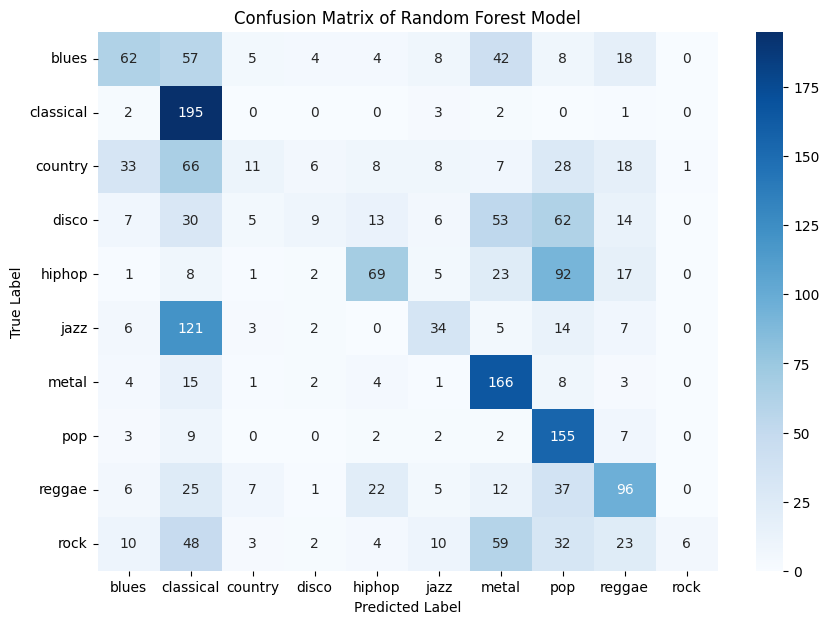

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test_pred and y_test are defined from previous code cells

# Evaluate the Random Forest model
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)

print("\nClassification Report for Random Forest:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Random Forest Model")
plt.show()


Model 4: Principal Component Analysis (PCA) + Logistic Regression

In [ ]:
# Model 4: Principal Component Analysis (PCA) + Logistic Regression

Model 5: Gaussian Mixture Model (GMM) + Expectation Maximization

In [ ]:
# Model 5: Gaussian Mixture Model (GMM) + Expectation Maximization



Model 6: Artificial Neural Network (ANN)

In [ ]:
# Model 6: Artificial Neural Network (ANN)

Model 7: Clustering (DBSCAN)

In [ ]:
# Model 7: Clustering DBSCAN